In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
# Load dataset
df = pd.read_csv("test.csv")  # Ensure the file is in the same directory as your Jupyter Notebook


In [3]:
# Define performance categories based on grades
performance_mapping = {"DECLINED": -1, "SAME": 0, "IMPROVED": 1}
grade_columns = [
    "persona_definition_grade_comparison",
    "interactive_persona_grade_comparison",
    "data_driven_persona_grade_comparison",
    "dynamic_persona_grade_comparison"
]

df["performance_score"] = df[grade_columns].applymap(lambda x: performance_mapping[x]).sum(axis=1)

# Additional columns reflecting answer quality
answer_quality_mapping = {"LOW": -1, "MEDIUM": 0, "HIGH": 1}
quality_columns = [
    "data_collection_explanation_post_grade",
    "data_analysis_explanation_post_grade",
    "persona_building_explanation_post_grade",
    "evaluation_explanation_post_grade"
]

df["answer_quality_score"] = df[quality_columns].applymap(lambda x: answer_quality_mapping[x]).sum(axis=1)


In [4]:
# Combine both scores
df["total_score"] = df["performance_score"] + df["answer_quality_score"]

# Categorize participants into new performance groups
def categorize_performance(score):
    if score >= 3:
        return "High Performer"
    elif score >= 1:
        return "Medium Performer"
    else:
        return "Low Performer"

df["performance_group"] = df["total_score"].apply(categorize_performance)


In [5]:
# Print class distribution
print("Performance Group Distribution:")
print(df["performance_group"].value_counts())

Performance Group Distribution:
Low Performer       19
Medium Performer     6
High Performer       1
Name: performance_group, dtype: int64


In [6]:
# Encode categorical features
label_encoders = {}
for col in df.columns[1:-2]:  # Exclude participant_id, group_class, and performance_group
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode the target variable (performance_group)
target_encoder = LabelEncoder()
df["performance_group_encoded"] = target_encoder.fit_transform(df["performance_group"])

In [7]:
# Define features and target variable
X = df.drop(columns=["participant_id", "group_class", "performance_group", "performance_group_encoded"])
y = df["performance_group_encoded"]

# Regular Train-Test Split (removing stratify to avoid class size issue)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[target_encoder.inverse_transform([i])[0] for i in np.unique(y_test)])

print(f"SVM Model Accuracy: {accuracy:.2%}")
print("Classification Report:")
print(report)

SVM Model Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

Low Performer       1.00      1.00      1.00         6

     accuracy                           1.00         6
    macro avg       1.00      1.00      1.00         6
 weighted avg       1.00      1.00      1.00         6



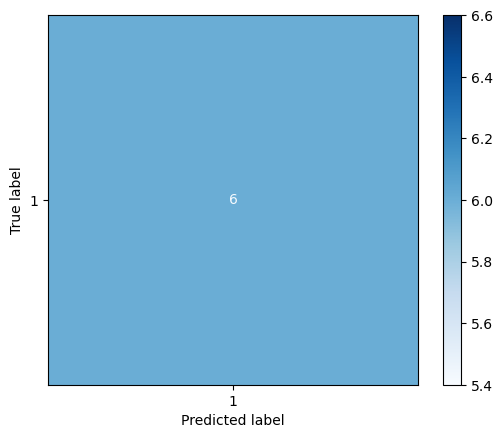

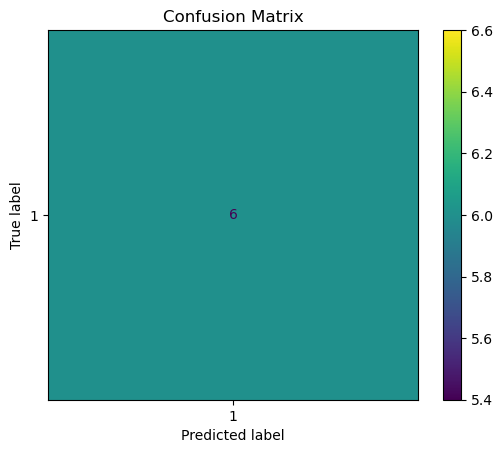

In [13]:
# Plot Confusion Matrix (Corrected)
disp = ConfusionMatrixDisplay.from_estimator(
    svm_model, X_test, y_test, display_labels=np.unique(y_test), cmap=plt.cm.Blues
)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Feature Importance Table:
                                    Feature  Importance
10                              total_score    0.309936
9                      answer_quality_score    0.157272
8                         performance_score    0.152664
2      data_driven_persona_grade_comparison    0.091569
3          dynamic_persona_grade_comparison    0.072839
7         evaluation_explanation_post_grade    0.072839
0       persona_definition_grade_comparison   -0.011743
1      interactive_persona_grade_comparison   -0.036419
4    data_collection_explanation_post_grade   -0.096325
6   persona_building_explanation_post_grade   -0.122042
5      data_analysis_explanation_post_grade   -0.133785


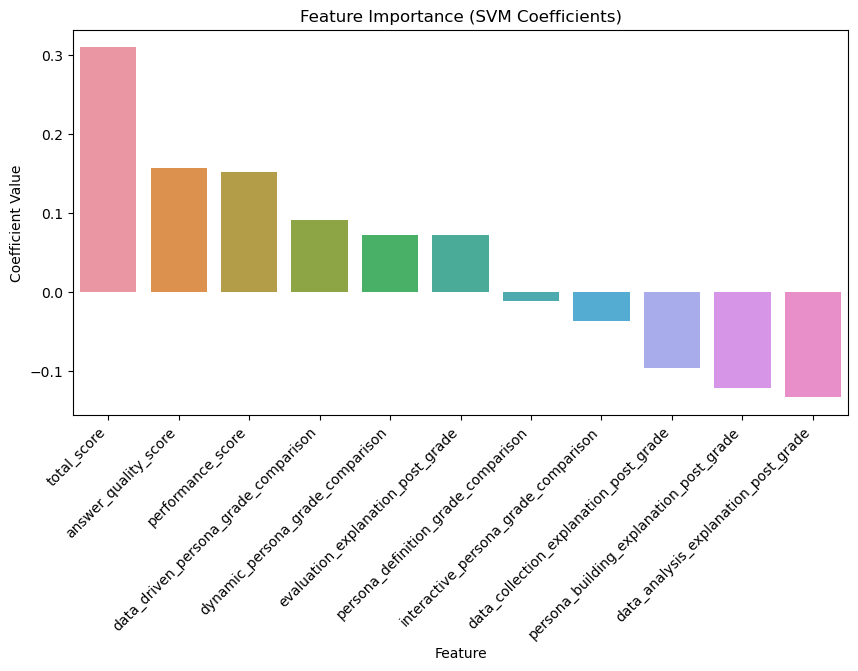

In [14]:
# Visualizing feature importance via coefficient magnitude and creating a table
if hasattr(svm_model, "coef_"):
    feature_importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": svm_model.coef_[0]
    }).sort_values(by="Importance", ascending=False)
    
    print("Feature Importance Table:")
    print(feature_importance)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importance["Feature"], y=feature_importance["Importance"])
    plt.xticks(rotation=45, ha='right')
    plt.title("Feature Importance (SVM Coefficients)")
    plt.ylabel("Coefficient Value")
    plt.show()

In [11]:
def classify_participant(data):
    processed_data = {}
    for col, le in label_encoders.items():
        if data[col] in le.classes_:
            processed_data[col] = le.transform([data[col]])[0]
        else:
            processed_data[col] = -1  # Assign an unseen category
    prediction = svm_model.predict([list(processed_data.values())])[0]
    return target_encoder.inverse_transform([prediction])[0]

In [12]:
# Display participant IDs with their assigned performance group
results_df = df[["participant_id", "performance_group"]].copy()
print(results_df)

    participant_id performance_group
0                1     Low Performer
1               23     Low Performer
2               22  Medium Performer
3               19     Low Performer
4               15     Low Performer
5               13  Medium Performer
6                7    High Performer
7               12  Medium Performer
8                4     Low Performer
9               25     Low Performer
10               2     Low Performer
11              26     Low Performer
12              14     Low Performer
13               5  Medium Performer
14               6  Medium Performer
15              21     Low Performer
16              17     Low Performer
17              24     Low Performer
18              16     Low Performer
19              10     Low Performer
20               3  Medium Performer
21               8     Low Performer
22               9     Low Performer
23              40     Low Performer
24              20     Low Performer
25              11     Low Performer


t-SNE failed, switching to PCA...


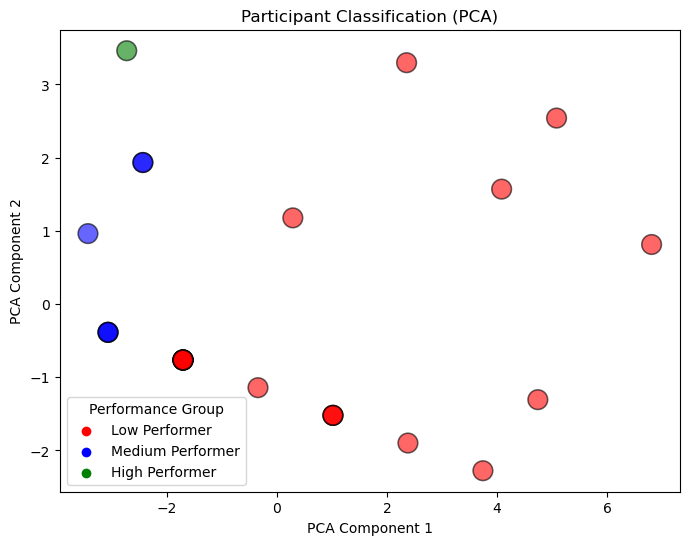

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Try t-SNE first, fallback to PCA if it fails
try:
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    X_embedded = tsne.fit_transform(X)
    method = "t-SNE"
except:
    print("t-SNE failed, switching to PCA...")
    pca = PCA(n_components=2)
    X_embedded = pca.fit_transform(X)
    method = "PCA"

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df["performance_group"], palette={
    "Low Performer": "red",
    "Medium Performer": "blue",
    "High Performer": "green"
}, alpha=0.6, s=200, edgecolor="black")
plt.title(f"Participant Classification ({method})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Performance Group")
plt.show()


# 	1.	PCA Component 1 (X-Axis)
#	•	Explains the most variance in the dataset.
#	•	Likely influenced by total_score, answer_quality_score, and performance_score (since they have high importance).
#	•	A higher PCA Component 1 value might indicate better overall performance.
#	2.	PCA Component 2 (Y-Axis)
#	•	Explains the second-most variance in the dataset.
#	•	Likely influenced by features like data_driven_persona_grade_comparison and evaluation_explanation_post_grade.
#	•	A higher PCA Component 2 value might indicate a difference in explanation quality rather than scores.

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
for col in df.columns[1:-2]:  # Exclude participant_id, group_class, and performance_group
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode the target variable (performance_group)
target_encoder = LabelEncoder()
df["performance_group_encoded"] = target_encoder.fit_transform(df["performance_group"])

# Encode group_class (Chatbot/Deepfake)
group_encoder = LabelEncoder()
df["group_class_encoded"] = group_encoder.fit_transform(df["group_class"])

# Convert encoded performance group back to original labels
df["performance_group"] = target_encoder.inverse_transform(df["performance_group_encoded"])

# Select features for PCA
X = df[["total_score", "answer_quality_score", "performance_score", "data_driven_persona_grade_comparison"]]
y = df["performance_group_encoded"]  # Using performance group as classification target

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Print variance explained
print(f"PCA Component 1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PCA Component 2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")

# Create scatter plot
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(8, 6))

# Define performance group colors
palette = {"Low Performer": "red", "Medium Performer": "blue", "High Performer": "green"}

sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], 
    hue=df["performance_group"],  # Now using original labels
    style=df["group_class"], 
    palette=palette, 
    markers={"Chatbot": "o", "Deepfake": "s"}, 
    alpha=0.6, s=200, edgecolor="black"
)

# Add group_class labels to each point with slight shifts for visibility
for i, txt in enumerate(df["group_class"]):
    plt.text(X_pca[i, 0] + 0.1, X_pca[i, 1] + 0.1, txt, fontsize=9, color='black', fontweight='bold')

plt.title("Participant Classification (PCA with Group Labels)")
plt.xlabel(f"Total & Answer Quality Score (Main Performance) ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)")
plt.ylabel(f"Persona & Explanation Skills ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)")
plt.legend(title="Performance Group & Group Class")
plt.show()

PCA Component 1 explains 76.79% of variance
PCA Component 2 explains 22.90% of variance


/var/folders/lj/tcwl5glj0blfftjn4df0129r0000gn/T/ipykernel_85491/3703667289.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


ValueError: The palette dictionary is missing keys: {0, 1, 2}

<Figure size 800x600 with 0 Axes>